# Project description
The following project is part of the final assignment for the course Data Science for Spatial Systems BEVGSA6. The project has for scope to explore and analyse spatially the topics and sentiments contained in the tweets produced in the corridor between London and Reading using methods learned through the course.
For more information please contact the author Carlos Padrón at padron.ca@gmail.com or carlos.florez.16@ucl.ac.uk. 
## Data
The tweets were gathered from Twitter (https://twitter.com/) using the Tweepy library (http://www.tweepy.org/). Tweets are from the period starting on the 2017-04-02 to 2017-04-04 and from a corridor between London and Reading defined by the wgs84 coordinates 51.30,-1.0 and 51.70,-0.2. Appendix A shows the code used to get and save the data. Table 1 and 2 show how the data looks after importing.

In [1]:
#imports libraries.
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import MySQLdb
import numpy as np
import pandas as pd
from cartopy.io.img_tiles import OSM
from IPython.display import Markdown, display
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import BoundaryNorm, ListedColormap
from palettable.colorbrewer.qualitative import Paired_12
from scipy.stats import chi2_contingency
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#adjusts matplotlib settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 11)

In [2]:
#connect to mysql database.
db = MySQLdb.connect(host = '213.171.200.78',
    user = 'curiouser',
    passwd = 'oKGIpI0q',
    db = 'curiocity'
    )
c = db.cursor()
#request table called tweets.
c.execute("""SELECT * FROM tweets""")
tweets = c.fetchall()
#creates dataframe with the tweets using the pandas library (McKinney, 2010).
tweetsDfColumns = ['id', 'user', 'text', 'x', 'y','created_at', 'lang']
tweetsDf = pd.DataFrame(list(tweets), columns = tweetsDfColumns)
#request table called users.
c.execute("""SELECT user, screen_name FROM user""")
users = c.fetchall()
#creates dataframe with the users.
usersDfColumns = ['user', 'screen_name'] 
usersDf = pd.DataFrame(list(users), columns = usersDfColumns)
#shows tweets dataframe head.
display(Markdown('**Table 1: Tweets dataframe head**'))
tweetsDf.head()

**Table 1: Tweets dataframe head**

,id,user,text,x,y,created_at,lang
0,848471783992946688,494113289,We are so waiting for The resaults of The Cast...,-0.192330,51.4989,2017-04-02 09:46:51,en
1,848471876603138048,540866116,Ich verlasse gerade London für einen kleinen A...,-0.178454,51.5170,2017-04-02 09:47:13,de
2,848471958329184256,1848566844,Hair and Makeup for this beaut daiz.may.hul at...,-0.826304,51.3504,2017-04-02 09:47:33,en
3,848471986426617856,21041936,Just stopping off for a quick 'nip &amp; tuck'...,-0.147700,51.5206,2017-04-02 09:47:40,en
4,848472009772339200,20716710,Sunday living beach life #beachlife @ Isle of ...,0.730000,51.4600,2017-04-02 09:47:45,en


All columns seem to have the right data type (table 3 and 4). There are no null values in the data and the period of time is correct (table 5). Unfortunately some tweets have a location out of the area of interest defined by the wgs84 coordinates 51.30,-1.0 and 51.70,-0.2 (table 6). We need to produce a new set of tables with the right coordinates (table 7).

In [3]:
#shows tweets dataframe types.
display(Markdown('**Table 3: Data types in Tweets dataframe**'))
print(tweetsDf.dtypes)
#shows if any of the values in tweets and hashtags dataframes are null.
#it also shows the period of time covered by the tweets.
display(Markdown('**Table 5: Null values and time period for Tweets**'))
print('Any null values in Tweets dataframe: ', tweetsDf.isnull().values.any().sum())
print('Period of time covered by the tweets: ', 
      tweetsDf['created_at'].min(), ' to ', tweetsDf['created_at'].max())
#produces basic statistics for the tweets coordinates.
display(Markdown('**Table 6: Range of coordinates for Tweets**'))
index = ['Min coordinates: ', 'Max coordinates: ']
print(pd.DataFrame({'x' : pd.Series([tweetsDf['x'].min(), tweetsDf['x'].max()], index = index),
              'y' : pd.Series([tweetsDf['y'].min(), tweetsDf['y'].max()], index = index)}))
#extracts tweets falling within the coordinates 51.30,-1.0 and 51.70,-0.2.
tweetsDf2 = tweetsDf.query('x >= -1.0 & x <= -0.2 & y >= 51.30 & y <= 51.70')
#produces basic statistics for the filtered tweets coordinates.
display(Markdown('**Table 7: Range of coordinates for filtered Tweets**'))
index = ['Min coordinates: ', 'Max coordinates: ']
print(pd.DataFrame({'x' : pd.Series([tweetsDf2['x'].min(), tweetsDf2['x'].max()], index = index),
              'y' : pd.Series([tweetsDf2['y'].min(), tweetsDf2['y'].max()], index = index)}))

**Table 3: Data types in Tweets dataframe**

id                     int64
user                   int64
text                  object
x                    float64
y                    float64
created_at    datetime64[ns]
lang                  object
dtype: object


**Table 5: Null values and time period for Tweets**

Any null values in Tweets dataframe:  0
Period of time covered by the tweets:  2017-04-02 09:46:51  to  2017-04-04 22:56:25


**Table 6: Range of coordinates for Tweets**

                          x         y
Min coordinates:   -52.2456  -7.32227
Max coordinates:   112.7530  54.93020


**Table 7: Range of coordinates for filtered Tweets**

                     x     y
Min coordinates:  -1.0  51.3
Max coordinates:  -0.2  51.7


Most tweets seem to be written in english (table 8). We can proceed with the analysis of the data with only those tweets in english.
Table 9 shows how 75% of the recorded users have 2 tweets or less. Very few users tweet more than 5 times in the study period and those top users are mostly streaming services for weather, news, jobs and similar (table 10). The data will be reduced to only users with less than 5 tweets.
Appendix A shows how during extraction tweets without coordinates or retweets were ignored. Although, there are tweets with duplicate text but the amount is less that the 4% of the total (table 11). These tweets can stay in the data without fear of affecting the analysis.

In [4]:
#counting tweets per language
display(Markdown('**Table 8: Language of Tweets**'))
print(tweetsDf2['lang'].value_counts())
#extracts tweets with known language
tweetsDf3 = tweetsDf2.query('lang == "en"')
#statistics on tweets by user
display(Markdown('**Table 9: Tweets by user**'))
print(tweetsDf3['user'].value_counts().describe())
#top twitters (tweets > 5)
display(Markdown('**Table 10: Users with more than 5 tweets**'))
userFrequency = tweetsDf3.set_index('user').join(usersDf.set_index('user'))
userFrequency2 = userFrequency['screen_name'].value_counts()
print(userFrequency2[userFrequency2 > 5])
#extracts tweets from users with less than 5 tweets
group = tweetsDf3.groupby('user')
tweetsDf4 = group.filter(lambda x: len(x) <= 5)
#shows stats of the amount of unique tweets
display(Markdown('**Table 11: Unique tweets**'))
print('Total tweets:', tweetsDf4['text'].count())
print('Unique tweets:', tweetsDf4['text'].nunique())
print('Amount of no unique tweets:', 
      tweetsDf4['text'].count() - tweetsDf4['text'].nunique())
print('Percentage of unique tweets:', 
      tweetsDf4['text'].nunique() / tweetsDf4['text'].count())

**Table 8: Language of Tweets**

en     5436
und     162
es       44
fr       39
in       23
ja       15
it       15
de       13
pt       13
nl       13
no       10
pl        9
da        8
ar        8
tr        8
et        8
ht        8
fi        6
tl        6
sv        5
ru        4
cy        3
zh        2
cs        2
th        1
lt        1
hu        1
ro        1
hi        1
Name: lang, dtype: int64


**Table 9: Tweets by user**

count    2525.000000
mean        2.152871
std         9.183570
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       353.000000
Name: user, dtype: float64


**Table 10: Users with more than 5 tweets**

WeatherWoking      353
VirtualJukebox     173
sgweather1         123
DailySURREY        108
SteelPanTrust       75
BryanGodfree        61
MWWeather           60
kt19weather         57
philford            55
_THFC_              48
ffc2004             46
grantsales          43
JobsAtContinuum     32
O2JobsFeed          31
GatwickFirst        27
WhatsOnOLIO         24
WokinghamWeatha     21
tmj_lon_health      20
DailyBUCKS          16
EchoSupplements     14
CEBJobs             13
tmj_lon_jobs        12
tmj_lon_sales       11
coffeeshotltd       11
johntuffrey         10
TimmyUk             10
saracens66           9
kickalert            8
Hulstone             8
tmj_lon_hrta         8
Voneron              8
JohnLeslieCoyl1      8
CharloTheLegend      7
tmj_lon_mgmt         7
lsfoodsuk            7
tmj_LON_manuf        6
ginnygae             6
Baldy4eva            6
CollektInfo          6
malsimons            6
darrenmoore          6
jmnish               6
Name: screen_name, dtype: int64


**Table 11: Unique tweets**

Total tweets: 3458
Unique tweets: 3341
Amount of no unique tweets: 117
Percentage of unique tweets: 0.966165413534


## Geographical distribution

Most of the tweets are in the area of London as shown on map 1. Outside London most of the tweets seem to be clustered around towns, villages and tourist attractions like Heathrow Airport and Windsor Castle. This is expected as population or users concentrate in those areas. We can perform a cluster analysis to test this hypothesis using the DBSCAN method from Scikit-Learn (Ester et al., 1996)(Pedregosa et al., 2011). This method requires the definition of the variable epsilon which was set to 0.2 to keep towns separated from each other or from London (map 2). 
Most towns outside London are center of their own cluster (see Reading, Slough, Maidenhead etc on map2). The case is different for London which only one cluster was formed due to a larger spatial coverage of tweets. 
These clusters will be used to analyse the content of the tweets in the next section.

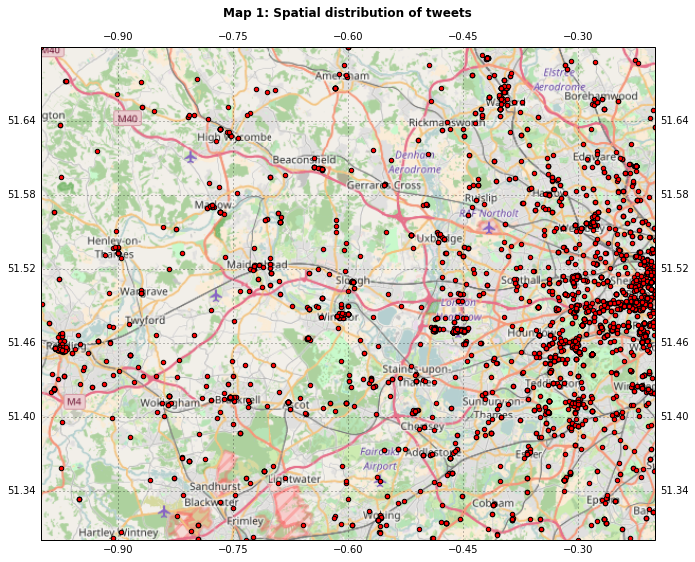

Contains © OpenStreetMap data


In [5]:
##Plots distribution of tweets using matplotlib (Hunter, 2007) 
##and cartopy (Met Office, 2010)

#creates an openstreetmap instance  
osm_tiles = OSM()
#use the tile's projection for the underlying map
ax = plt.axes(projection = osm_tiles.crs)
#defines and sets limits for the plot
xlim = [-1.0,-0.2]
ylim = [51.30,51.70]
ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],
              ccrs.PlateCarree()) 
#add the tiles at zoom level 10
ax.add_image(osm_tiles, 10)
#add grids and labels
ax.gridlines(draw_labels = True)
#creates the tweets layer
tweetsDf4.plot(ax = ax,
               kind = 'scatter', 
               x = 'x', 
               y = 'y', 
               color = 'red',
               transform = ccrs.PlateCarree())
#adds title
plt.title('Map 1: Spatial distribution of tweets', y=1.05, weight = 'bold')
plt.show()
print('Contains © OpenStreetMap data')

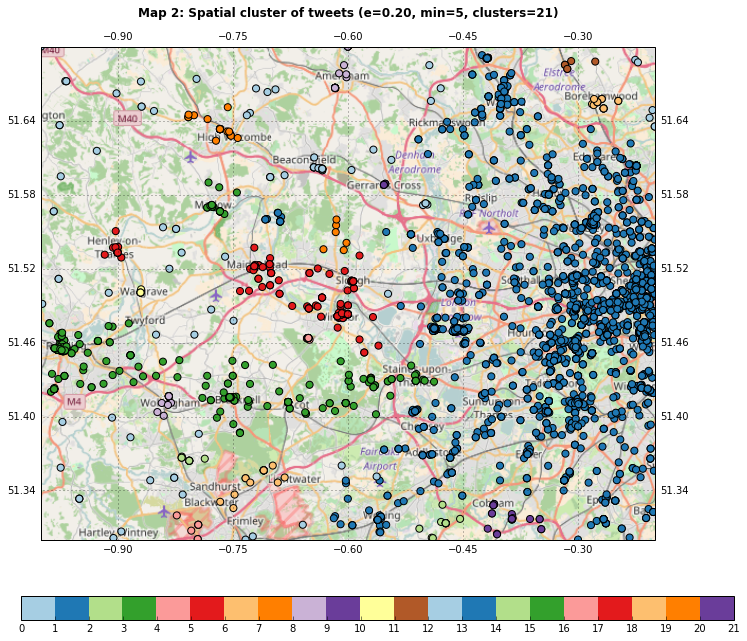

Contains © OpenStreetMap data


In [6]:
##Plots cluster of tweets using matplotlib (Hunter, 2007) 
##and cartopy (Met Office, 2010)

#extracts the coordinates of the tweets
data = tweetsDf4[['x','y']]
#transforms the coordinates into a matrix
data = data.as_matrix().astype("float32", copy = False)
#standarises the values for better performance of dbscan and other algorithms
stscaler = StandardScaler().fit_transform(data)
#performs a Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
e = 0.2
#m = 10
dbsc = DBSCAN(
              eps = e, 
              #min_samples = m
             ).fit(stscaler)
#extracts the labels
labels = dbsc.labels_
#calculates amount of clusters ignoring noise
n_clusters = (len(set(labels)) - (1 if -1 in labels else 0))
m = dbsc.get_params()['min_samples']
#creates a new table with the labels
tweetsDf5 = tweetsDf4.assign(spatialCluster = labels)  
#creates an openstreetmap instance with cartopy (Met Office, 2010)
osm_tiles = OSM()
#creates figure for plotting
fig = plt.figure()
#use the tile's projection for the underlying map
ax = plt.subplot(projection = osm_tiles.crs)
#defines and sets limits for the plot
xlim = [-1.0,-0.2]
ylim = [51.30,51.70]
ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],
              ccrs.PlateCarree()) 
#add the tiles at zoom level 10
ax.add_image(osm_tiles, 10)
#add grids and labels
ax.gridlines(draw_labels = True)
#creates the tweets layer
cmap = ListedColormap(Paired_12.mpl_colors, N = n_clusters+1)
ax.scatter(x = tweetsDf5['x'], 
           y = tweetsDf5['y'], 
           c = tweetsDf5['spatialCluster'],
           s = 50,
           #alpha = .7,
           cmap = cmap,
           transform = ccrs.PlateCarree())
#adds title
plt.title('Map 2: Spatial cluster of tweets (e=%.2f, min=%i, clusters=%i)'
          %(e, m, n_clusters), y=1.05, weight = 'bold')
#adds colorbar
ax2 = fig.add_axes([0.1, 0.1, 0.9, 0.03])
bounds = np.linspace(0,n_clusters,n_clusters+1)
norm = BoundaryNorm(bounds, cmap.N)
cb = ColorbarBase(
                  ax2,
                  cmap = cmap, 
                  norm = norm, 
                  spacing = 'proportional', 
                  ticks = bounds, 
                  boundaries = bounds, 
                  orientation = 'horizontal',
                  format = '%1i')
plt.show()
print('Contains © OpenStreetMap data')

## Topic and Sentiment analysis
### Topic analysis
This second part of the analysis is focused on the topic and sentiment found in the tweets.
The first step is to extract all terms used in the tweets and reduce the weights of those too frequent using the TF-IDF method from Scikit-Learn (Sparck Jones, 1972)(Pedregosa et al., 2011). Table 12 shows that the most frequent word is 'https' which are the web links included in the text; all web links will be excluded from further analysis.
The rest of the frequent words are related to what it seems sport events, parks, etc. Table 13 shows an extension of this frecuency analysis to bi-grams. These bi-grams reflect how London is a main leisure center as they refer to the Heathrow Airport, Wembley Stadium, the Warner Bros studios and the Boat race at Putney that happened during those days.
The second step is to extract the topics using the Scikit-Learn implementation of the NMF method (Cichocki and Anh-Huy, 2009)(Pedregosa et al., 2011). Table 14 and 15 show how the most frequent topic is related to the words "sunday spring happy time morning love today sunshine sunny good" which is just a reflection of the period when the tweets were collected (over a weekend). The following most common topic is "heathrow", "warner bros studio" and "wimbledon" which are well known tourist attractions.
The next step is to extract and analyse the sentiment contained in the tweets.

In [7]:
#parameters for text extraction
n_topics = 10
n_top_words = 10
n_features = 1000
#counts the frequency of words in the tweets
vectorizer = TfidfVectorizer(min_df = 1,
                            stop_words = 'english')
v = vectorizer.fit_transform(tweetsDf5['text'])
totalFreq = np.asarray(np.sum(v, axis = 0))[0]
words = vectorizer.get_feature_names()
wordsDf = pd.DataFrame({'word': words, 'frequency': totalFreq})
display(Markdown('**Table 12: Top frequent words in Tweets**'))
print(wordsDf.sort_values(by = 'frequency', ascending = False ).head(20))
#extracts URL links from text
tweetsDf6 = tweetsDf5
tweetsDf6['text'] = tweetsDf6['text'].replace(
    to_replace = 'https://t.co/..........', value = '', regex = True)
#counts the frequency of words in the tweets (filtered tweets)
vectorizer = TfidfVectorizer(min_df = 1,
                            stop_words = 'english')
v = vectorizer.fit_transform(tweetsDf6['text'])
totalFreq = np.asarray(np.sum(v, axis = 0))[0]
words = vectorizer.get_feature_names()
wordsDf = pd.DataFrame({'word': words, 'frequency': totalFreq})
##counts the frequency of bi-grams in the tweets
vectorizer2 = TfidfVectorizer(min_df = 1,
                            stop_words = 'english',
                            ngram_range=(2, 2))
v2 = vectorizer2.fit_transform(tweetsDf6['text'])
totalFreq2 = np.asarray(np.sum(v2, axis = 0))[0]
words2 = vectorizer2.get_feature_names()
wordsDf2 = pd.DataFrame({'word': words2, 'frequency': totalFreq2})
display(Markdown('**Table 13: Top frequent bi-grams in Tweets**'))
print(wordsDf2.sort_values(by = 'frequency', ascending = False ).head(20))
#performs topic extraction
nmf = NMF(
          n_components = n_topics
        ).fit(v)
def print_top_words(nmf, words, n_top_words):
    for topic_id, topic in enumerate(nmf.components_):
        print("Topic #%d:" % topic_id)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
display(Markdown('**Table 14: Topic extraction from tweets**'))
print_top_words(nmf, words, n_top_words)
#clasifies tweets into topics
tweetTopic = nmf.transform(v)
#assigns to every tweet the most relevant topic
topic = []
for i in tweetTopic:
    topic.append(i.argmax())
tweetsDf7 = tweetsDf6.assign(topic = topic)
#prints frequency per topic
display(Markdown('**Table 15: Tweets per topic**'))
tweetsDf7['topic'].value_counts()

**Table 12: Top frequent words in Tweets**

       frequency             word
4345  166.433126            https
5311   95.573754           london
2505   53.898687              day
4801   40.886297             just
9463   40.289343          wembley
6511   32.056788             park
3881   31.658415          greater
1423   30.943745             boat
7132   30.843033             race
8743   29.770913            today
4314   29.754261         hounslow
8307   28.172110           sunday
3880   27.172716            great
4135   26.969359  heathrowairport
6642   26.747498            photo
8696   25.410586             time
6813   25.314518           posted
8090   25.306952           spring
8136   24.621921          stadium
848    24.076417              amp


**Table 13: Top frequent bi-grams in Tweets**

       frequency                      word
5819   36.825793            greater london
6256   30.655524  heathrowairport hounslow
7061   28.564096               just posted
1704   27.944026                 boat race
14807  26.853238           wembley stadium
6557   25.529325          hounslow greater
10288  24.880277              posted photo
7897   23.523797    london heathrowairport
13135  12.380353  terminal heathrowairport
11036  11.464772             richmond park
6248   11.344586         heathrow terminal
10530  11.255511             putney bridge
5768    9.479290                 great day
5985    8.253151        hammersmith bridge
9672    8.129997          oxford cambridge
12567   8.020178               studio tour
14465   7.773764               warner bros
2057    7.483772               bros studio
4351    7.092811      endomondo endorphins
13756   6.691913               tour london


**Table 14: Topic extraction from tweets**

Topic #0:
london greater heathrowairport hounslow lhr station wimbledon bros warner studio
Topic #1:
just posted photo video heathrow kingsmeadow maidenhead stadium studio bridge
Topic #2:
wembley stadium pusb ccfc city coventry checkatrade football oxford oufc
Topic #3:
race boat oxford cambridge thames 2017 ready vs river barnes
Topic #4:
hounslow heathrowairport terminal heathrow greater queen home lounge galleries ba
Topic #5:
day great amazing yesterday beautiful lovely today good sunny pusb
Topic #6:
park richmond allianz trip thames bushy richmondpark bishops holland saracens
Topic #7:
putney bridge oxford hammersmith boatrace cambridge river barnes boatrace2017 railway
Topic #8:
job hiring england careerarc great reading work latest fit opening
Topic #9:
sunday spring happy time morning love today sunshine sunny good



**Table 15: Tweets per topic**

9    1417
0     513
5     307
8     305
6     217
1     191
7     164
3     122
2     121
4     101
Name: topic, dtype: int64

### Sentiment analysis
The sentiments were extracted using the VADER Sentiment library (Hutto and Gilbert, 2014). VADER is a parsimonious rule-based model that uses a sentiment lexicon to classify the data into four categories ("compound", "neutral", "positive" and "negative"). Figure 1 shows a set of histograms for every sentiment found. Most of the tweets were classified as "neutral", followed in proportion by the "positive" category and finally by the "negative" category. Some clusters have a larger median of "positive" sentiment than other clusters (figure 2) and the same applies for the topics (figure 3). 
Map 3 show the location of the clusters 1, 10 and 18 which have the most "positive" content and table 16 the most frequent words for those clusters. These seem to be related to weekend events at the park or at least outside of any town with some of the most frequent words being "love" and "rugby".
Table 17 shows the most frequent words for the topics 5 and 8 which have the most "positive" tweets with some of them being "great" and "amazing" which are clearly positive words. 
This analysis was not extended to the "negative" sentiment due to its low presence.

**Figure 1: Sentiments contained in tweets**

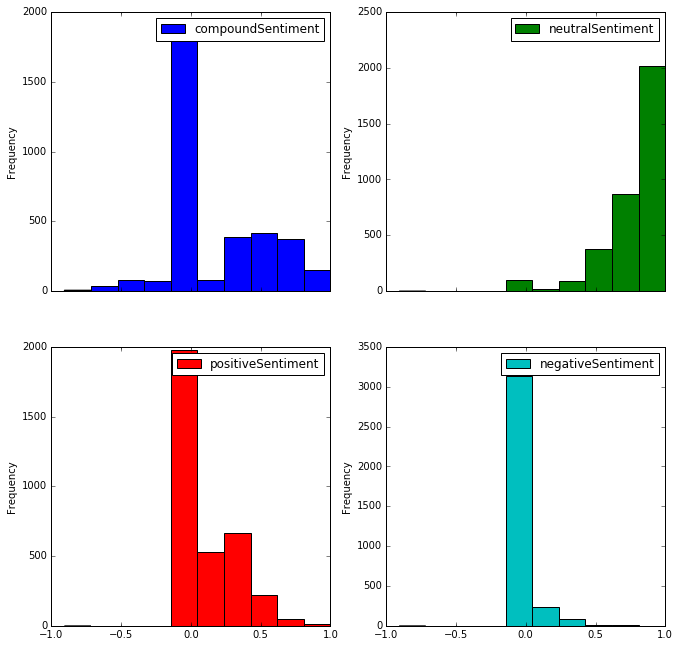

**Figure 2: Median positive sentiment in tweets per cluster**

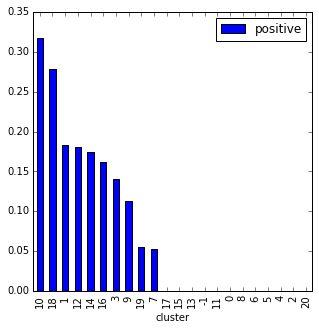

**Figure 3: Median positive sentiment in tweets per topic**

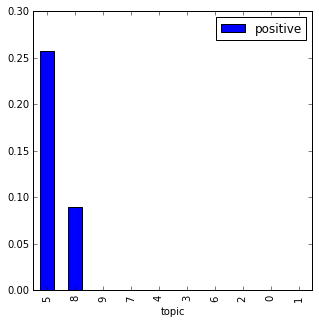

In [8]:
#Extract sentiment for every tweet
analyzer = SentimentIntensityAnalyzer()
compound = []
neutral = []
positive = []
negative = []
for tweet in tweetsDf7['text']:
    vs = analyzer.polarity_scores(tweet)
    compound.append(vs['compound']) 
    neutral.append(vs['neu']) 
    positive.append(vs['pos'])
    negative.append(vs['neg']) 
#Add columns for every sentiment category
tweetsDf8 = tweetsDf7.assign(compoundSentiment = compound)
tweetsDf8 = tweetsDf8.assign(neutralSentiment = neutral)
tweetsDf8 = tweetsDf8.assign(positiveSentiment = positive)
tweetsDf8 = tweetsDf8.assign(negativeSentiment = negative)
#plots an histogram of the sentiments
display(Markdown('**Figure 1: Sentiments contained in tweets**'))
tweetsDf8[['compoundSentiment', 
           'neutralSentiment',
           'positiveSentiment',
           'negativeSentiment']].plot(#ax = ax,
                                      kind = 'hist',
                                      subplots = True,
                                      #title = 'Figure 1: Sentiments contained in tweets',
                                      layout = (2,2)
                                     )
plt.show()
#calculate and plot median of postivite tweets per cluster
clusters = tweetsDf8['spatialCluster'].unique()
positive = []

for i in clusters:
    df = tweetsDf8[tweetsDf8['spatialCluster'] == i]
    positive.append(df['positiveSentiment'].median()) 

sentimentDf = pd.DataFrame({'cluster' : clusters,
                            'positive': positive})
sentimentDf = sentimentDf.sort_values(by = 'positive', ascending = False)
display(Markdown('**Figure 2: Median positive sentiment in tweets per cluster**'))
sentimentDf.plot(kind = 'bar',
                 x = 'cluster',
                 y = 'positive',
                 figsize = (5,5)
                 )
plt.show()
#calculate and plot median of positive tweets per topic
topics = tweetsDf8['topic'].unique()
positive2 = []

for i in topics:
    df = tweetsDf8[tweetsDf8['topic'] == i]
    positive2.append(df['positiveSentiment'].median()) 

sentimentDf2 = pd.DataFrame({'topic' : topics,
                            'positive': positive2})
sentimentDf2 = sentimentDf2.sort_values(by = 'positive', ascending = False)
display(Markdown('**Figure 3: Median positive sentiment in tweets per topic**'))
sentimentDf2.plot(kind = 'bar',
                 x = 'topic',
                 y = 'positive',
                 figsize = (5,5)
                 )
plt.show()

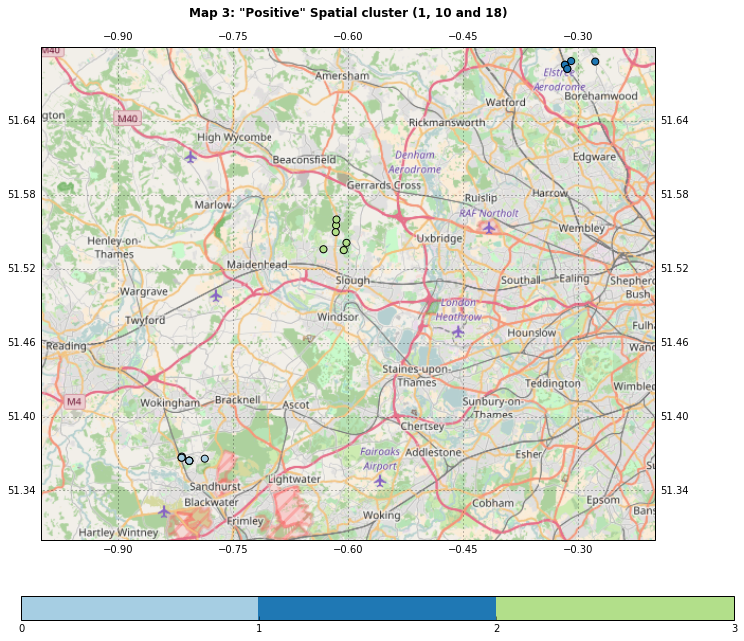

Contains © OpenStreetMap data


**Table 16: Top frequent words in "positive" clusters (1, 10 18)**

     frequency      word
19    0.787820       box
70    0.783161      love
99    0.755929     rugby
121   0.740236  tlrailuk
66    0.723481      lads
40    0.687957  enjoying
20    0.686936      boys
63    0.630424      just
75    0.605446   morning
97    0.603023     right


**Table 17: Top frequent words in "positive" topics (5 and 8)**

      frequency       word
491   32.723816        day
819   17.420418      great
978   12.742507        job
95    11.974626    amazing
2094  11.191227  yesterday
2071  11.090137       work
2049  10.931044    windsor
899   10.640508     hiring
623    9.866249    england
1481   9.680428    reading


In [9]:
tweetsDfpositiveCluster = tweetsDf8.query('spatialCluster in [10,18,1]')
#creates an openstreetmap instance with cartopy (Met Office, 2010)
osm_tiles = OSM()
#creates figure for plotting
fig = plt.figure()
#use the tile's projection for the underlying map
ax = plt.subplot(projection = osm_tiles.crs)
#defines and sets limits for the plot
xlim = [-1.0,-0.2]
ylim = [51.30,51.70]
ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],
              ccrs.PlateCarree()) 
#add the tiles at zoom level 10
ax.add_image(osm_tiles, 10)
#add grids and labels
ax.gridlines(draw_labels = True)
#creates the tweets layer
cmap = ListedColormap(Paired_12.mpl_colors, N = 3)
ax.scatter(x = tweetsDfpositiveCluster['x'], 
           y = tweetsDfpositiveCluster['y'], 
           c = tweetsDfpositiveCluster['spatialCluster'],
           s = 50,
           #alpha = .7,
           cmap = cmap,
           transform = ccrs.PlateCarree())
#adds title
plt.title('Map 3: "Positive" Spatial cluster (1, 10 and 18)', y=1.05, weight = 'bold')
#adds colorbar
ax2 = fig.add_axes([0.1, 0.1, 0.9, 0.03])
bounds = np.linspace(0,3,4)
norm = BoundaryNorm(bounds, cmap.N)
cb = ColorbarBase(
                  ax2,
                  cmap = cmap, 
                  norm = norm, 
                  spacing = 'proportional', 
                  ticks = bounds, 
                  boundaries = bounds, 
                  orientation = 'horizontal',
                  format = '%1i')
plt.show()
print('Contains © OpenStreetMap data')
#counts the frequency of word in clusters 1, 10 and 18
vectorizer3 = TfidfVectorizer(min_df = 1,
                            stop_words = 'english')
v3 = vectorizer3.fit_transform(tweetsDfpositiveCluster['text'])
totalFreq3 = np.asarray(np.sum(v3, axis = 0))[0]
words3 = vectorizer3.get_feature_names()
wordsDf3 = pd.DataFrame({'word': words3, 'frequency': totalFreq3})
display(Markdown('**Table 16: Top frequent words in "positive" clusters (1, 10 18)**'))
print(wordsDf3.sort_values(by = 'frequency', ascending = False ).head(10))
#counts the frequency of word in topic 8
tweetsDfpositiveTopic = tweetsDf8.query('topic in [5,8]')
vectorizer4 = TfidfVectorizer(min_df = 1,
                            stop_words = 'english')
v4 = vectorizer4.fit_transform(tweetsDfpositiveTopic['text'])
totalFreq4 = np.asarray(np.sum(v4, axis = 0))[0]
words4 = vectorizer4.get_feature_names()
wordsDf4 = pd.DataFrame({'word': words4, 'frequency': totalFreq4})
display(Markdown('**Table 17: Top frequent words in "positive" topics (5 and 8)**'))
print(wordsDf4.sort_values(by = 'frequency', ascending = False ).head(10))

### Sentiment independency from topic or location
Finally, it would be good to check if the sentiments found are independent from the location or clusters and from the topics. In other words, are the tweets "positive" because they originate in "positive" places like parks or because they are related to "positive" topics like "great day".
The independency was tested with a Chi-square test using the implementation from the Scipy library (Eric Jones et al., 2001). Table 18 shows the contingency table for the sentiment categories vs the spatial clusters. All frequencies less than 5 were removed as this affects the test, including the column for "negative" sentiment as for some clusters is 0.
The resulting p-value is higher than 0.5 and we can conclude that there is no enough evidence that the sentiments are dependent of the spatial clusters (table 19).
The second test is to confirm dependency between the sentiments and the topics. All frequencies less than 5 were also removed without the need of dropping any of the sentiment columns (table 20). The p-value in this case is considerably lower than 0.5 and the test statistic is high, we can say that there is dependency between the tweet sentiment and the tweet topic (table 21).

In [11]:
#transform the compound sentiment into categories
sentimentCategory = pd.cut(x = tweetsDf8['compoundSentiment'],
                           bins = 3, 
                           labels = ['negative', 'neutral', 'positive'])
#add sentiment categories to tweets dataframe
tweetsDf9 = tweetsDf8.assign(sentimentCategory = sentimentCategory)
#creates matrix for chi-square independece test (sentiments per cluster)
negative = []
neutral = []
positive = []

for i in clusters:
    df = tweetsDf9[tweetsDf9['spatialCluster'] == i]
    df2 = df[df['sentimentCategory'] == 'negative']
    df3 = df[df['sentimentCategory'] == 'neutral']
    df4 = df[df['sentimentCategory'] == 'positive']
    negative.append(df2['sentimentCategory'].count())
    neutral.append(df3['sentimentCategory'].count())
    positive.append(df4['sentimentCategory'].count())
sentimentsPerCluster = pd.DataFrame({'cluster': clusters,
                                    'negative': negative,
                                    'neutral': neutral,
                                    'positive': positive})
#extract those values bigger or equal than 5
display(Markdown('**Table 18: Frequency of sentiments per cluster**'))
print(sentimentsPerCluster)
sentimentsPerCluster2 = sentimentsPerCluster.query('neutral >=5 & positive >=5')
sentimentsPerCluster2 = sentimentsPerCluster2[['neutral', 'positive']]
#performs chi-square independece test
chi2, p, ddof, expected = chi2_contingency( sentimentsPerCluster2.values )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
display(Markdown('**Table 19: Chi-squared independence test (sentiments vs cluster)**'))
print( msg.format( chi2, p, ddof ) )
#creates matrix for chi-square independece test (sentiments per topic)
negative = []
neutral = []
positive = []

for i in topics:
    df = tweetsDf9[tweetsDf9['topic'] == i]
    df2 = df[df['sentimentCategory'] == 'negative']
    df3 = df[df['sentimentCategory'] == 'neutral']
    df4 = df[df['sentimentCategory'] == 'positive']
    negative.append(df2['sentimentCategory'].count())
    neutral.append(df3['sentimentCategory'].count())
    positive.append(df4['sentimentCategory'].count())
sentimentsPerTopic = pd.DataFrame({'topic': topics,
                                    'negative': negative,
                                    'neutral': neutral,
                                    'positive': positive})
#extract those values bigger or equal than 5
display(Markdown('**Table 20: Frequency of sentiments per topic**'))
print(sentimentsPerTopic)
sentimentsPerTopic2 = sentimentsPerTopic.query('neutral >=5 & positive >=5')
sentimentsPerTopic2 = sentimentsPerTopic2[['negative', 'neutral', 'positive']]
#performs chi-square independece test
chi2, p, ddof, expected = chi2_contingency( sentimentsPerTopic2.values )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
display(Markdown('**Table 21: Chi-squared independence test (sentiments vs topic)**'))
print( msg.format( chi2, p, ddof ) )

**Table 18: Frequency of sentiments per cluster**

    cluster  negative  neutral  positive
0        -1         6       43        25
1         0       110     1677       978
2         1         1        3         5
3         2        19      128        95
4         3         0        8         5
5         4         6       81        40
6         5         1       11         5
7         6         3       14         7
8         7         1        9         8
9         8         2       12         9
10        9         1        2         3
11       10         0        2         4
12       11         1       13         5
13       12         0        7         7
14       13         1        9         3
15       14         2       11        11
16       15         0        6         1
17       17         0        8         7
18       16         1        8         8
19       18         0        1         5
20       19         0       11         3
21       20         0        4         1


**Table 19: Chi-squared independence test (sentiments vs cluster)**

Test Statistic: 10.07062981177693
p-value: 0.6881487669248617
Degrees of Freedom: 13



**Table 20: Frequency of sentiments per topic**

   negative  neutral  positive  topic
0        78      769       570      9
1         6      122        36      7
2         6       79        16      4
3        20      162       123      8
4         5       84        33      3
5         8      154        55      6
6         5       92        24      2
7        13      328       172      0
8         7      120       180      5
9         7      158        26      1


**Table 21: Chi-squared independence test (sentiments vs topic)**

Test Statistic: 207.54383663210743
p-value: 3.0904238216754233e-34
Degrees of Freedom: 18



## Conclusions
This project intended to explore and analyse spatially the topics and sentiments contained in the tweets produced from the period starting on the 2017-04-02 to 2017-04-04 in the corridor between London and Reading. 
After the data cleansing, the data showed potential of spatial clustering that was confirmed using the DBSCAN method. Due to a higher amount of tweets and spatial coverage London ended as one big cluster while most of the towns outside London are center of their own cluster.
Topics were also extracted from the tweets using the TF-IDF method followed by the NMF method. The topics showed the relevance of tourism in London but also showed how people were involved in what it seems weekend activities.
Using the VADER Sentiment library the sentiments were extracted from the tweets. Most tweets resulted "neutral" followed by "positive" and some "negative" at the end.
Some spatial clusters and topics showed more "positive" content than others. The most "positive" clusters turn out to be places out of town like parks with frequent words like "love" and "rugby". The most positive topics were related to words like "great" and "amazing".
To finish, a chi-squared test was performed to test if the sentiments were dependent of the spatial clusters or from the topics. No enough evidence was found to confirm dependency between sentiment and spatial clusters but there was enough evidence to confirm dependency between sentiment and topic.
This work can be improved with a larger dataset of tweets, a improved selection of tecniques and parameters.

## References
Cichocki, A., Anh-Huy, P., 2009. Fast local algorithms for large scale nonnegative matrix and tensor factorizations. IEICE transactions on fundamentals of electronics, communications and computer sciences 92, 708–721.

Eric Jones, Travis Oliphant, Pearu Peterson, 2001. SciPy: Open Source Scientific Tools for Python.

Ester, M., Kriegel, H.-P., Sander, J., Xu, X., 1996. A density-based algorithm for discovering clusters in large spatial databases with noise. AAAI Press, pp. 226–231.

Hunter, J.D., 2007. Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering 9, 90–95. doi:10.1109/MCSE.2007.55

Hutto, C.J., Gilbert, E., 2014. Vader: A parsimonious rule-based model for sentiment analysis of social media text, in: Eighth International AAAI Conference on Weblogs and Social Media.

McKinney, W., 2010. Data Structures for Statistical Computing in Python, in: Proceedings of the 9th Python in Science Conference. pp. 51–56.

Met Office, 2010. Cartopy: a cartographic python library with a matplotlib interface. Exeter, Devon.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, É., 2011. Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research 12, 2825–2830.

Sparck Jones, K., 1972. A statistical interpretation of term specificity and its application in retrieval. Journal of Documentation 28, 11–21. doi:10.1108/eb026526

Tweepy, URL http://www.tweepy.org/.

Twitter, URL https://twitter.com/.

## Appendix A: Getting the data

The following code was used to extract the data and save it into a mysql table. There is no need to run the code as the data is already saved.

#importing libraries
import MySQLdb
import tweepy

#stream tweets (code based on https://www.dataquest.io/blog/streaming-data-python/)
consumer_key = 'consumer_key'
consumer_secret = 'consumer_secret'
access_token = 'access_token-LD5BGDNFiYAwN04urJ7alkWIpaQDvMoXcvCBYMrs'
access_secret = 'access_secret'
 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)


locations = [-1.0,51.30,-0.2,51.70]

class MyStreamListener(tweepy.StreamListener):

    def on_status(self, status):
        #avoids getting tweets without coordinates or retweets
        if  status.coordinates is None or hasattr(status, 'retweeted_status'):
            return
        
        #extracts tweets values
        created_at = status.created_at
        id = status.id
        text = status.text
        user = status.user.id_str
        x = status.coordinates['coordinates'][0]
        y = status.coordinates['coordinates'][1]
        lang = status.lang
        
        #connect to mysql database
        db = MySQLdb.connect(host = '213.171.200.78',
                     user = 'user',
                     passwd = 'passwd',
                     db = 'db'
                     )
        c = db.cursor()
        
        #sets everything to utf8
        db.set_character_set('utf8')
        c.execute('SET NAMES utf8;')
        c.execute('SET CHARACTER SET utf8;')
        c.execute('SET character_set_connection=utf8;')
        
        #inserts tweets and hashtags
        c.execute("""INSERT INTO tweets (created_at, id, text, user, x, y, lang) 
          VALUES (%s, %s, %s, %s, %s, %s, %s)""", (created_at, id, text, user, x, y, lang))
        
        for i in status.entities['hashtags']:
            hashtags = i['text']
            c.execute("""INSERT INTO hashtags (id, hashtags) 
              VALUES (%s, %s)""", (id, hashtags))
                  
                
    def on_error(self, status_code):
        if status_code == 420:
            return False
        
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener = myStreamListener)
myStream.filter(locations = locations)

#gets user details
#connect to mysql database
db = MySQLdb.connect(host = '213.171.200.78',
                     user = 'user',
                     passwd = 'passwd',
                     db = 'db'
                     )
c = db.cursor()
#request table called tweets.
c.execute("""SELECT DISTINCT user FROM tweets""")
users = c.fetchall()

for i in users:
    #gets user details 
    user = api.get_user(i[0])
    #connect to mysql database
    db = MySQLdb.connect(host = '213.171.200.78',
                     user = 'user',
                     passwd = 'passwd',
                     db = 'db'
                     )
    #sets everything to utf8
    db.set_character_set('utf8')
    c.execute('SET NAMES utf8;')
    c.execute('SET CHARACTER SET utf8;')
    c.execute('SET character_set_connection=utf8;')
    #inserts into table user details
    c.execute("""INSERT INTO user (user, screen_name)
              VALUES (%s, %s)""", (user.id, user.screen_name))